In [0]:
%sh
pip install wordcloud
python3 -m PIL

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-d66d2f4a-93ca-4ba4-b37c-00eae0d77495/bin/python -m pip install --upgrade pip' command.
--------------------------------------------------------------------
Pillow 9.5.0
Python 3.9.5 (default, Nov 23 2021, 15:27:38)
       [GCC 9.3.0]
--------------------------------------------------------------------
Python modules loaded from /local_disk0/.ephemeral_nfs/envs/pythonEnv-d66d2f4a-93ca-4ba4-b37c-00eae0d77495/lib/python3.9/site-packages/PIL
Binary modules loaded from /local_disk0/.ephemeral_nfs/envs/pythonEnv-d66d2f4a-93ca-4ba4-b37c-00eae0d77495/lib/python3.9/site-packages/PIL
--------------------------------------------------------------------
--- PIL CORE support ok, compiled for 9.5.0
*** TKINTER support not installed
--- FREETYPE2 support ok, loaded 2.13.0
--- LITTLECMS2 support ok, loaded 2.15
--- WEBP support ok, loaded 1.3.0
--- WEBP Transparency support ok
--- WEBPMUX support ok
--- WEBP Animation su

In [0]:
pip install --upgrade pillow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
#import pyspark and other required libraries
import pyspark
from pyspark.sql import SparkSession


#Create spark session
spark = SparkSession.builder.getOrCreate()
from pyspark.sql import functions as F

In [0]:
#Importing libraries for visualisations
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum
from wordcloud import WordCloud

In [0]:
#dbutils.fs.mv('/FileStore/tables/skill2vec_50K_csv.gz', '/FileStore/tables/skill2vec_50K.csv.gz')

In [0]:
#read the input file into a Dataframe
jd = spark.read.csv('/FileStore/tables/skill2vec_50K.csv.gz')

#Sanity check - verify if the data has loaded correctly
print("number of records:" ,jd.count())

number of records: 50000


In [0]:
#column 0 - identifier and column 1 - the skills list
jd_columns = jd.columns[1:]
jdlistDF = jd.select(jd.columns[0], F.array( jd_columns ).alias( 'jd_skills_list') )

#rename the first column as jd_identifier
jdlistDF = jdlistDF.withColumnRenamed('_c0','jd_identifier')

#remove all the nulls and create and new column with only data
jd_non_nullDF = jdlistDF.withColumn ( 'jd_skills_list_not_null' , F.array_except('jd_skills_list' , F.array(F.lit(None))))

In [0]:
#Q1: sanity check: to see if there are any null values in the jd_identifier
print("Number of rows in job identifier is with null:", jd_non_nullDF.where(jd_non_nullDF.jd_identifier == 'null').count())

Number of rows in job identifier is with null: 0


In [0]:
#Question 1:
#Programmatically confirm that the number of job descriptions is as expected (i.e. that
#there are 50,000 distinct job numbers / identifers / description in the skill2vec 50K dataset).
print("Distinct number of job descriptions: ", jd_non_nullDF.select('jd_identifier').distinct().count())

Distinct number of job descriptions:  50000


In [0]:
#Question 2:
#Work out the frequencies with which distinct skills are mentioned in job descriptions,
#and present the top 10 (in order of decreasing frequency) skills in your report, alongside
#the frequency of each across the entire dataset. I.e. if your dataset consists of the
#following:

#count the number of jobs listed in the description and add a column with the count in it
jd_non_nullDF_count = jd_non_nullDF.withColumn ( 'Num_skills' , F.size ( 'jd_skills_list_not_null' ) )

#Q2 - Sanity check: Every JD identifier has at least one skill
print("Number of jobs with no skills :", jd_non_nullDF_count.where(jd_non_nullDF_count.Num_skills < 1).count() )

#Explode the array into individual records
ind_jd_DF = jd_non_nullDF_count.withColumn("Skills", F.explode(F.col('jd_skills_list_not_null')))

#Groupby to find the count of individual job skills
ind_jd_count_DF = ind_jd_DF.groupBy('Skills').count()

#rename the ind_jd_skills to skills
ind_jd_count_DF = ind_jd_count_DF.withColumnRenamed('count','Freq') 

Number of jobs with no skills : 0


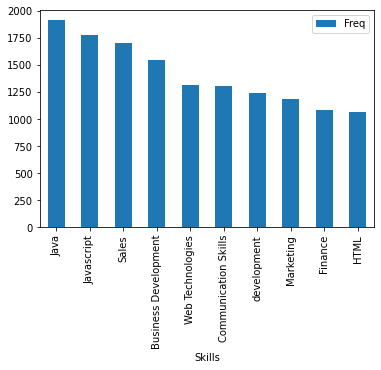

In [0]:
#Create a dataframe for the top 10 records
ind_jd_count_DF_top10 =ind_jd_count_DF.orderBy(ind_jd_count_DF["Freq"].desc()).limit(10)

# Convert Spark DataFrame to pandas DataFrame
pan_ind_jd_count_DF_top10 = ind_jd_count_DF_top10.toPandas()

# Plotting a bar chart using pandas
pan_ind_jd_count_DF_top10.plot(x='Skills', y='Freq', kind='bar')
plt.show()

In [0]:
#To find skills in different case sensitive formats
ind_jd_count_DF.where(F.col('Skills').isin("java", "Java", "JAva", "JAVa", "JAVA")).show(truncate = False)

+------+----+
|Skills|Freq|
+------+----+
|java  |784 |
|Java  |1911|
|JAva  |1   |
|JAVA  |63  |
+------+----+



In [0]:
#group by identifier , skill and 
id_skill_cnt = ind_jd_DF.groupby('jd_identifier', 'Skills').count()

#check if there are any duplicate skills listed in any jd
id_skill_cnt.where(F.col('count') > 1).show(5)

+-------------+------+-----+
|jd_identifier|Skills|count|
+-------------+------+-----+
+-------------+------+-----+



In [0]:
#Find the number of jobs that have the same number of skills
num_skills_count = jd_non_nullDF_count.groupBy('Num_skills').count()

#Question 3:
#Find the 5 most frequent numbers of skills in JDs across the dataset. I.e. given the
#example with JD1, JD2 and JD3 above, the expected result would be:
num_skills_count.sort('count', ascending=False).show(5,truncate = False)

+----------+-----+
|Num_skills|count|
+----------+-----+
|10        |10477|
|5         |3432 |
|6         |3405 |
|1         |3386 |
|7         |3345 |
+----------+-----+
only showing top 5 rows



<command-253061284277621>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  num_skills_count_top5_pan = num_skills_count_top5_pan.append({'Num_skills': 'Others', 'count': 25955}, ignore_index=True)


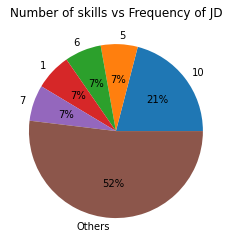

In [0]:
#Order by number of skills in descreasing order and select only top 5
num_skills_count_sort = num_skills_count.orderBy(num_skills_count["count"].desc())

#Select the top5 records
num_skills_count_top5 = num_skills_count.orderBy(num_skills_count["count"].desc()).limit(5)

#select records other than the top5
num_skills_count_others = num_skills_count_sort.select('count').where(F.col('count') < 3345)

#convert to pandas
num_skills_count_others_pan = num_skills_count_others.toPandas()

#calcuate the others categories count
others_count = num_skills_count_others_pan.sum()

# Convert Spark DataFrame to pandas DataFrame
num_skills_count_top5_pan = num_skills_count_top5.toPandas()

#Append another row with others and its counts to get the correct distribution in the pie chart
num_skills_count_top5_pan = num_skills_count_top5_pan.append({'Num_skills': 'Others', 'count': 25955}, ignore_index=True)

# Create the pie chart with labels
plt.pie(num_skills_count_top5_pan['count'], labels=num_skills_count_top5_pan['Num_skills'], autopct='%1.0f%%')

# Add a title to the chart
plt.title('Number of skills vs Frequency of JD')

# Display the chart
plt.show()

In [0]:
#Display 5 minimum number of skills listed in a job description 
num_skills_count.sort('Num_skills', ascending=True).show(5,truncate = False)

#Display 5 maximum number of skills listed in a job description
num_skills_count.sort('Num_skills', ascending=False).show(5,truncate = False)

+----------+-----+
|Num_skills|count|
+----------+-----+
|1         |3386 |
|2         |2463 |
|3         |2637 |
|4         |3138 |
|5         |3432 |
+----------+-----+
only showing top 5 rows

+----------+-----+
|Num_skills|count|
+----------+-----+
|960       |1    |
|695       |1    |
|556       |1    |
|508       |1    |
|458       |1    |
+----------+-----+
only showing top 5 rows



In [0]:
#explore the job description to check if the skills are correct
jd_non_nullDF_count.where(F.col('Num_skills') == 960).display()

jd_identifier jd_skills_list jd_skills_list_not_null Num_skills 9496 List(java, jee, j2ee, aws, s3, ec2, elb, cassandra, nosql, mongodb, soa, web_services, restful, rest, high_volume, high_availability, high_performance, distributed_systems, cloud, saas, paas, complex_java_nosql, back-end, serverside, java_cloud, web_services_nosql, million, billion, complex, startup, start_up, co-founder, founder, hackathon, competition, finalist, winner, patent_-talent_-recruiter_-scientist, c++, linux, jquery, html5/css3/javascript, sql, javascript, php, python, front-end, apis, spring, api, ios, objective_c, applications, mobile, react.js, mysql, css, j2se, j2me, javase, javame, javaseb, c#, c, java_script, js, java-script, full_stack, fullstack, html5, bootstrap, distributed_system, big_data, machine_learning, hadoop, mapreduce, map-reduce, large_scale, parallel_programming, data_analytics, data_mining, math, statistics, js_framework, javascript_framework, tool, tools, engine, games_pc, console, rendering, renderer, render, games_console, pc, engineer, programming, programmer, tool_creation, tools_maintenance, design_tools, games, visual_effects_industry, .net, asp.net, windows, mobile_applications, web_applications, android, ood, html/css, angular, ember, backbone, sass, less, asp, hibernate, front_end, mac_os_x, os_x, xen, kvm, qemu, lxc, openstack, makefile, javaee, j2seb, object-oriented_design, object_oriented_design, object_oriented, data_structures, datastructures, data-structures, oop, object-oriented_programming, object_oriented_programming, e-commerce, ecommerce, e_commerce, object-oriented, frontend, online_retail, online_payments, online_payment, large_enterprise_systems, solr, search, research, recommendation, recommend, recommender, swift, cocoa, app_development, cocoa_touch, algorithms, algorithm_design, c/c++, distributed-systems, data_algorithms, problem_solving, ios_client_app, ios_app, cocoa-touch, framework, frameworks, objective-c, uikit, gcd, autlayout, ios_memory_management, html, perl, ruby, yui, dojo, prototype, ajax, full-stack, javascripts, java_scripts, computer_science, software_engineer, tv_platforms, people_manager, web, application, web_api, entity_framework, wpf, bs/ms_in_computer_science, react, node, node.js, objectivec, ios_application, algorithm, complexity, sharepoint, html/html5, css/css3, wcf, oo, moss, microsoft_office_sharepoint_server, tfs, git, obj-c, obj_c, large_computer_systems, distributed_programming, distributed_algorithm, distributed_computing, distributed_operating_system, distributed_application, distributed_program, docker, rdbms, bash, shell, css3, engines, quality_assurance, software, wifi, firmware, audio, video, media, codecs, codec, hevc, aac, gerrit, graphics, graphic, consoles, xbox_one, ps4, xbox, ps3, playstation, network, protocols, networking, servers, server/clients, clients, client, client/server, multiplayer, mmo, mp, gaming, odesign, objectoriented_design, kernel, mongo.db, mdb, movement, signal_processing, sensors, embedded_linux, vxworks, threadx, freertos, rtos, infrastructure, storage, cs, computer_science_degree, jvm, haskell, akka_or_erlang, scala, web_app, web_apps, web_application, agile, postgresql, shell_scripting, shell_script, shell_scripts, map_reduce, hive, hdfs, hbase, unix, ubuntu, redhat, debian, data_pipelines, smartphone, tablet, spring_framework, spring_mvc, spring_frameworks, multithreaded, multithreading, nlp, natural_language_processing, back_end, stream_processing, data, spark, mpi, unity, unity3d, developer, gameplay, game-play, game_play, first-person_shooters, fps, dynamics_ax, ax, microsoft_dynamics_ax_2012, microsoft_dynamics_ax, net, performance, native_app_development, media_codec, exoplayer, object_oriented_programming_oop, customize, customization, custom, dot_net, ax_r2, ax_r3, ado.net, apps, app, release_engeneering, release, release/build, build/release, release_and_build, build, sdk, development_kit, salesforce, server-side, mvc, mvcs

In [0]:
#Question 4:
#So far, you’ve explored the dataset in its original form. Check how the distribution of
#the frequencies with which distinct skills are mentioned in JDs changes if you lower case
#all the skills. As in question 2, present the top 10 (in order of decreasing frequency)
#skills in your report.

#Create a new column with individual columns in lower case
ind_jd_lower_DF = ind_jd_DF.withColumn("Skills_lower", F.lower(F.col('Skills')))

#groupby to find the count of the jobs in lower case
ind_jd_lower_count_DF = ind_jd_lower_DF.groupBy('Skills_lower').count()

#Display the top 10 
ind_jd_lower_count_DF.sort('count', ascending=False).show(10,truncate = False)

+--------------------+-----+
|Skills_lower        |count|
+--------------------+-----+
|java                |2759 |
|javascript          |2738 |
|sales               |2680 |
|business development|2108 |
|marketing           |1809 |
|sql                 |1564 |
|jquery              |1547 |
|html                |1539 |
|communication skills|1537 |
|bpo                 |1530 |
+--------------------+-----+
only showing top 10 rows



In [0]:
ind_jd_lower_count_DF.where(F.col('Skills_lower').like("java%")).show(10, truncate = False)

+------------------------------------+-----+
|Skills_lower                        |count|
+------------------------------------+-----+
|java / j2ee programming             |2    |
|java_caps                           |6    |
|java developer.                     |1    |
|javaserver_faces                    |12   |
|java consultant                     |2    |
|java overriding                     |1    |
|java freshers                       |1    |
|java faculty in software engineering|1    |
|javascript (jquery)                 |1    |
|javascript or jsp                   |1    |
+------------------------------------+-----+
only showing top 10 rows



In [0]:
#Exploring the data for just one skill changing to lowercase
ind_jd_lower_count_DF.where(F.col('Skills_lower').isin("javascript", "java script", "java_script", "java-script", " javascript" "javascript ", " javascript ")).show(truncate = False)

#import regexp_replace function
from pyspark.sql.functions import regexp_replace

# replace character other than alphabets, numbers and hash, dot and plus
skills_transformed = ind_jd_lower_count_DF.withColumn("Skills_transformed", regexp_replace(ind_jd_lower_count_DF["Skills_lower"], "[^a-zA-Z0-9#.+]", ""))

#groupby to find the count of the skills after transformation
skills_transformed_count = skills_transformed.groupBy('Skills_transformed').sum('count')

#rename the column from sum(count) to new_count
skills_transformed_count = skills_transformed_count.withColumnRenamed('sum(count)','new_count')

#Exploring the data after removing spaces and the special characters
skills_transformed_count.where(F.col('Skills_transformed').isin("javascript", "java script", "java_script", "java-script", " javascript" "javascript ", " javascript ")).show(truncate = False)

#Display the new count after transformation
skills_transformed_count.sort('new_count', ascending=False).show(10,truncate = False)

+------------+-----+
|Skills_lower|count|
+------------+-----+
|javascript  |2738 |
|java-script |14   |
|java script |69   |
|java_script |28   |
+------------+-----+

+------------------+---------+
|Skills_transformed|new_count|
+------------------+---------+
|javascript        |2849     |
+------------------+---------+

+-------------------+---------+
|Skills_transformed |new_count|
+-------------------+---------+
|javascript         |2849     |
|java               |2760     |
|sales              |2680     |
|businessdevelopment|2163     |
|marketing          |1809     |
|communicationskills|1647     |
|sql                |1566     |
|jquery             |1551     |
|customerservice    |1545     |
|html               |1540     |
+-------------------+---------+
only showing top 10 rows



In [0]:
#Exploring the data after removing spaces and the special characters
skills_transformed_count.where(F.col('Skills_transformed').like('%java%')).show(15, truncate = False)

+---------------------------------------------------------------------+---------+
|Skills_transformed                                                   |new_count|
+---------------------------------------------------------------------+---------+
|corejavadevelopment                                                  |1        |
|javadevelopers                                                       |4        |
|c#andjavascriptframeworks                                            |1        |
|cibequitiesapollocorejavaapplicationsdevelopervicepresiden           |1        |
|java16                                                               |1        |
|cssjavascript                                                        |3        |
|corejavaxmlandroideclipseidesoapdesignpatternsalgorithmsdatastructure|1        |
|juniorsoftwareengineerjavaswing                                      |1        |
|javajsp                                                              |1        |
|technicalarchit

In [0]:
from pyspark.sql.functions import col, concat_ws
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover

#concat all the values of all the elements in an array to string
jd_non_nullDF_new = jd_non_nullDF.withColumn("skills_list", concat_ws(",",col("jd_skills_list_not_null")))

#lower the column value
jd_txt_lower = jd_non_nullDF_new.withColumn('skills_list', lower(jd_non_nullDF_new['skills_list'])) 

# replace special character
jd_txt_trans = jd_txt_lower.withColumn("skills_list", regexp_replace(jd_txt_lower["skills_list"], "[^a-zA-Z0-9\\s]", ""))

# Tokenize the text in the "title" column
tokenizer = Tokenizer(inputCol="skills_list", outputCol="skills")
tokenized_jd = tokenizer.transform(jd_txt_trans)

# Remove stop words from the tokenized words
stop_words = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol="skills", outputCol="filtered_skills", stopWords=stop_words)
filtered_jd = remover.transform(tokenized_jd)

# Explode the "filtered_words" array into rows
exploded_jd = filtered_jd.select(explode("filtered_skills").alias("skills"))

# Filter out non-letters and empty strings
skills_frequency = exploded_jd.filter((exploded_jd.skills != "") & exploded_jd.skills.rlike("^[a-zA-Z]+$"))

#Group by skills
skills_frequency1 = skills_frequency.groupby('skills').count()

# select top 10 words
top_freq_jd = skills_frequency1.orderBy(skills_frequency1["count"].desc()).limit(10)
top_freq_jd.show(10)

+-------------+-----+
|       skills|count|
+-------------+-----+
|   management| 2874|
|        sales| 2533|
|  development| 2323|
|      manager| 1438|
|          amp| 1372|
|     business| 1237|
|      support| 1181|
|communication| 1089|
|    executive|  992|
|    marketing|  958|
+-------------+-----+



In [0]:
#dbutils.fs.cp('/FileStore/tables/TechnologySkills.txt', '/FileStore/tables/Technology_Skills.txt')

In [0]:
#Question 5:
#To gain some additional information about the sought after skills, you’d like to join
#the (lower cased) skills from JDs with the skills listed in the Example column in the
#O*NET dataset (don’t forget to lower case the example column!). Find the change in
#the number of skills before and after the join (i.e. report the number of original skills
#and the skills that are both in the JD dataset and the O*NET dataset { reporting two
#separate numbers).

#read the input file into a Dataframe
Tech_skills = spark.read.format('csv') \
   .option('header', 'true') \
   .option('delimiter', '\t') \
   .load('dbfs:/FileStore/tables/Technology_Skills.txt')

#Convert Example column to lower case
Tech_skills_lower = Tech_skills.withColumn("Example_lower", F.lower(F.col('Example')))

#To print the count before join
print("Count of JD skills before join:" , ind_jd_lower_DF.select('Skills_lower').count() )

#Join the 2 dataframe using skills
join_jd = ind_jd_lower_DF.join(Tech_skills_lower , ind_jd_lower_DF['Skills_lower'] == Tech_skills_lower['Example_lower'] , 'inner')

#To print the count before join
print("Count of JD skills after join with Tech skills = ", join_jd.count())

Count of JD skills before join: 463803
Count of JD skills after join with Tech skills =  1101498


In [0]:
print(Tech_skills_lower.where(Tech_skills_lower.Example_lower == 'javascript').count())
Tech_skills_lower.where(Tech_skills_lower.Example_lower == 'javascript').show(10, truncate = False)

79
+--------------+----------+--------------+---------------------------------+--------------+---------+-------------+
|O*NET-SOC Code|Example   |Commodity Code|Commodity Title                  |Hot Technology|In Demand|Example_lower|
+--------------+----------+--------------+---------------------------------+--------------+---------+-------------+
|11-2011.00    |JavaScript|43232408      |Web platform development software|Y             |N        |javascript   |
|11-2021.00    |JavaScript|43232408      |Web platform development software|Y             |N        |javascript   |
|11-3021.00    |JavaScript|43232408      |Web platform development software|Y             |N        |javascript   |
|11-3131.00    |JavaScript|43232408      |Web platform development software|Y             |N        |javascript   |
|11-9041.00    |JavaScript|43232408      |Web platform development software|Y             |N        |javascript   |
|13-1111.00    |JavaScript|43232408      |Web platform development so

In [0]:
#To print the count before join
print("Count of JD skills before join:" , ind_jd_lower_DF.select('Skills_lower').count() )

#technical skills is grouped by to get only distinct commodity title and skills combinations
Tech_skills_commodity = Tech_skills_lower.groupby('Commodity Title','Example_lower').count()

#Join lowercase skills from job description with the lowercase skills from the new techical skills dataset
join_jd_new = ind_jd_lower_DF.join(Tech_skills_commodity , ind_jd_lower_DF['Skills_lower'] == Tech_skills_commodity['Example_lower'] , 'inner')
print("Count after the join of JD skill with groupedby commodity titel and skills = ", join_jd_new.count())

Count of JD skills before join: 463803
Count after the join of JD skill with groupedby commodity titel and skills =  24051


In [0]:
# replace character other than alphabets, numbers and hash, dot and plus
Tech_skills_trans = Tech_skills_lower.withColumn("Example_trans", regexp_replace(Tech_skills_lower["Example_lower"], "[^a-zA-Z0-9#.+]", ""))

#technical skills is grouped by to get only distinct commodity title and skills combinations
Tech_skills_commodity = Tech_skills_trans.groupby('Commodity Title','Example_trans').count()

print("Count before join of JD transformed skill :" , skills_transformed_count.select('Skills_transformed').count() )

#Join transformed skills from job description with the transformed skills from techical skills
join_jd_new = skills_transformed_count.join(Tech_skills_commodity , skills_transformed_count['Skills_transformed'] == Tech_skills_commodity['Example_trans'] , 'inner')
print("Count after the join of JD transformed skill with transformed Tech skills = ", join_jd_new.count())

Count before join of JD transformed skill : 51495
Count after the join of JD transformed skill with transformed Tech skills =  404


In [0]:
#Question 6:
#The join you performed in Question 5 gives you access to the \Commodity Title" column. Find the 10 most frequent \Commodity Title"s across all the job descriptions.
#I.e. using the example from Question 2, the output should be:
join_jd_count = join_jd.groupby('Commodity Title').count()
join_jd_count.sort('count', ascending=False).show(10,truncate = False)

+-------------------------------------------------+------+
|Commodity Title                                  |count |
+-------------------------------------------------+------+
|Object or component oriented development software|324521|
|Web platform development software                |298754|
|Operating system software                        |190926|
|Development environment software                 |53013 |
|Data base management system software             |44132 |
|Analytical or scientific software                |33552 |
|Web page creation and editing software           |31682 |
|Data base user interface and query software      |29436 |
|Spreadsheet software                             |18568 |
|File versioning software                         |13846 |
+-------------------------------------------------+------+
only showing top 10 rows



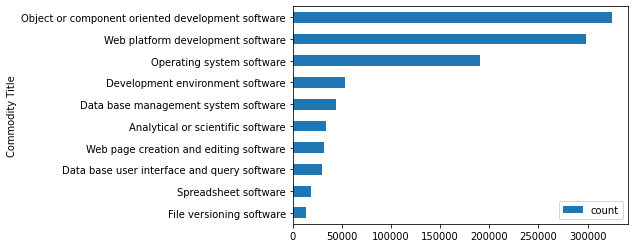

In [0]:
#Create a dataframe for the top 10 records
join_jd_count_top10 = join_jd_count.orderBy(join_jd_count["count"].desc()).limit(10)

#Sort the top10 in ascending order for horizontal bar chart
join_jd_count_top10 = join_jd_count_top10.orderBy(join_jd_count_top10['count'].asc())

# Convert Spark DataFrame to pandas DataFrame
pan_join_jd_count_top10 = join_jd_count_top10.toPandas()

# Plotting a horizontal bar chart using pandas
ax = pan_join_jd_count_top10.plot.barh(x='Commodity Title', y='count')
plt.show()

In [0]:
join_jd_count_new = join_jd_new.groupby('Commodity Title').sum('new_count')
join_jd_count_new.sort('sum(new_count)', ascending=False).show(10,truncate = False)

+-------------------------------------------------+--------------+
|Commodity Title                                  |sum(new_count)|
+-------------------------------------------------+--------------+
|Web platform development software                |7476          |
|Object or component oriented development software|5291          |
|Operating system software                        |2826          |
|Data base management system software             |2160          |
|Data base user interface and query software      |1754          |
|Development environment software                 |1616          |
|Web page creation and editing software           |674           |
|Program testing software                         |607           |
|Analytical or scientific software                |590           |
|Configuration management software                |419           |
+-------------------------------------------------+--------------+
only showing top 10 rows



In [0]:
#To use word cloud and to fix the truetype font error install the below packages 
#%sh
#pip install wordcloud


In [0]:
#python3 -m PIL
#pip install --upgrade pillow

In [0]:
#To use word cloud import the below packages
import matplotlib.pyplot as plt
from wordcloud import WordCloud

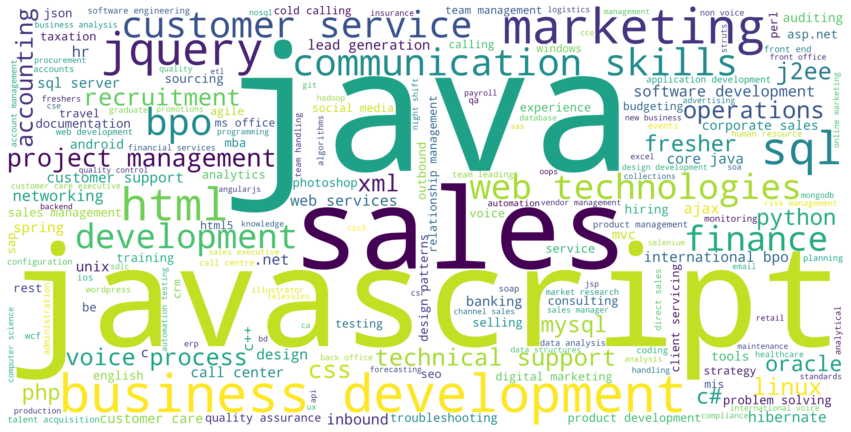

In [0]:
#convert dataframe to dictonary
skills_count_dict = {row['Skills_lower']: row['count'] 
              for row in ind_jd_lower_count_DF.collect()}
                
# Creating word_cloud with dictonary as argument in generate_from_frequencies() method
word_cloud = WordCloud(collocations = False, background_color = 'white', height = 5000, width = 10000).generate_from_frequencies(skills_count_dict)

# Display the generated Word Cloud
plt.figure(figsize=(15,15))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()